In [1]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

d:\dl\envs\gluon\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
d:\dl\envs\gluon\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
d:\dl\envs\gluon\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.
d:\dl\envs\gluon\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\dl\envs\gluon\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\dl\envs\gluon\lib\site-packages\

In [2]:
import tensorflow as tf
print(tf.__version__)

1.13.1


In [6]:
# set variables 
main_folder = 'dataset/'
images_folder = main_folder + 'img_align/'

EXAMPLE_PIC = images_folder + '000506.jpg'

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20

In [7]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv(main_folder + 'list_attr.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

In [8]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


Smiling    1
Male       0
Young      1
Name: 000506.jpg, dtype: int64

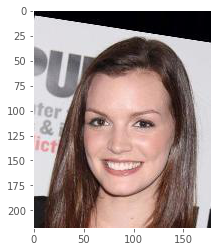

In [9]:
# plot picture and attributes
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young']] #some attributes

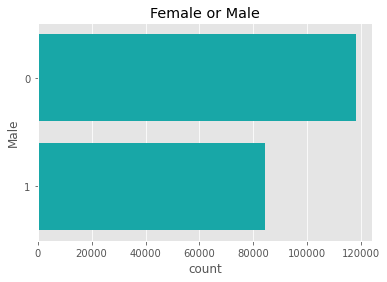

In [10]:
# Female or Male?
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr, color="c")
plt.show()

In [11]:
# Recomended partition
df_partition = pd.read_csv(main_folder + 'list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


d:\dl\envs\gluon\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


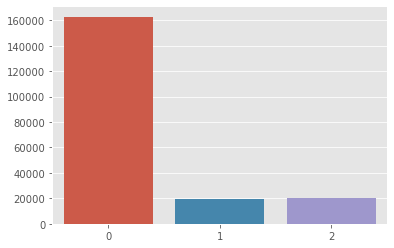

In [17]:
df_partition=pd.read_csv('dataset/list_eval_partition.csv')
df_p=df_partition['partition'].value_counts().sort_index()
sns.barplot(list(range(0,3)),list(df_p))
plt.savefig('dataset_ratio',dpi=400)

In [10]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [11]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

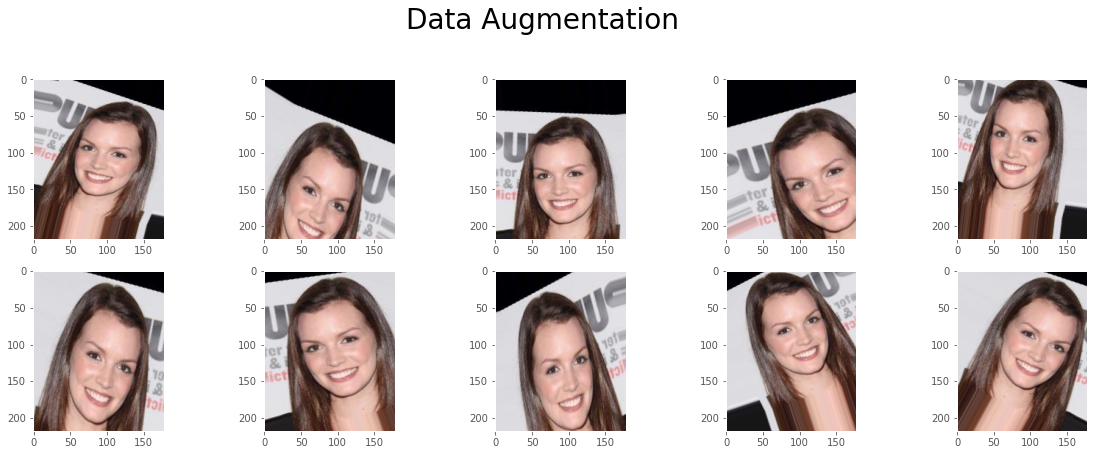

In [12]:
datagen =  ImageDataGenerator(
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)


plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

In [ ]:
def generate_df(partition, attr, num_samples):
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)

    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)
x_test, y_test = generate_df(, 'Male', VALIDATION_SAMPLES)


In [13]:
# Train data
x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [14]:
# Validation Data
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)

'''
# Validation - Data Preparation - Data Augmentation with generators
valid_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
)

valid_datagen.fit(x_valid)

validation_generator = valid_datagen.flow(
x_valid, y_valid,
)
'''

'\n# Validation - Data Preparation - Data Augmentation with generators\nvalid_datagen = ImageDataGenerator(\n  preprocessing_function=preprocess_input,\n)\n\nvalid_datagen.fit(x_valid)\n\nvalidation_generator = valid_datagen.flow(\nx_valid, y_valid,\n)\n'

## 导入库，设置好超参数

In [15]:
import os  
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

import keras
import numpy as np
import math

from keras.datasets import cifar10
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers import Flatten, Dense, Dropout,BatchNormalization,Activation, Convolution2D
from keras.models import Model
from keras.layers import Input, concatenate
from keras import optimizers, regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import he_normal
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint


num_classes        = 2
batch_size         = 64         # 64 or 32 or other
epochs             = 300
iterations         = 782       
USE_BN=True
DROPOUT=0.2 # keep 80%
CONCAT_AXIS=3
weight_decay=1e-4
DATA_FORMAT='channels_last' # Theano:'channels_first' Tensorflow:'channels_last'

log_filepath  = './inception_v4'

## 数据预处理并设置 learning schedule

In [16]:

def color_preprocessing(x_train,x_test):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    mean = [125.307, 122.95, 113.865]
    std  = [62.9932, 62.0887, 66.7048]
    for i in range(3):
        x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
        x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]
    return x_train, x_test

def scheduler(epoch):
    if epoch < 100:
        return 0.01
    if epoch < 200:
        return 0.001
    return 0.0001

# # load data
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test  = keras.utils.to_categorical(y_test, num_classes)
# x_train, x_test = color_preprocessing(x_train, x_test)


In [17]:
x_train.shape

(10000, 218, 178, 3)

## 定义网络结构

In [18]:
def conv_block(x, nb_filter, nb_row, nb_col, border_mode='same', strides=(1,1), bias=False):
    x = Conv2D(nb_filter, (nb_row,nb_col), strides=strides,padding=border_mode,bias=bias,
                     init="he_normal",dim_ordering='tf',kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = Activation('relu')(x)
    return x


def create_stem(img_input,concat_axis):
    x = Conv2D(32,kernel_size=(3,3),strides=(2,2),padding='same',
               kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay))(img_input)
    x = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(x))
    x = Conv2D(32,kernel_size=(3,3),strides=(1,1),padding='same',
               kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(x))    
    x = Conv2D(64,kernel_size=(3,3),strides=(1,1),padding='same',
               kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(x))
    # stem1
    x_1 = Conv2D(96,kernel_size=(3,3),strides=(2,2),padding='same',
               kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay))(x)
    x_1 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(x_1))
    x_2 = MaxPooling2D(pool_size=(3,3),strides=2,padding='same',data_format=DATA_FORMAT)(x) 
    x = concatenate([x_1,x_2],axis=concat_axis)
    # stem2
    x_1 = Conv2D(64,kernel_size=(1,1),strides=(1,1),padding='same',
                 kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay))(x)
    x_1 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(x_1))
    x_1 = Conv2D(96,kernel_size=(3,3),strides=(1,1),padding='same',
                 kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay))(x_1)
    x_1 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(x_1))
    
    x_2 =  Conv2D(96,kernel_size=(1,1),strides=(1,1),padding='same',
                  kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay))(x)
    x_2 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(x_2))
    x_2 = conv_block(x_2,64,1,7)
    x_2 = conv_block(x_2,64,7,1)
    x_2 =  Conv2D(96,kernel_size=(3,3),strides=(1,1),padding='same',
                  kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay))(x_2) 
    x_2 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(x_2))
    x = concatenate([x_1,x_2],axis=concat_axis)
    # stem3
    x_1 = Conv2D(192,kernel_size=(3,3),strides=(2,2),padding='same',
                 kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay))(x)
    x_1 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(x_1))
    x_2 = MaxPooling2D(pool_size=(3,3),strides=2,padding='same',data_format=DATA_FORMAT)(x) 
    x = concatenate([x_1,x_2],axis=concat_axis)
    return x


def inception_A(x,params,concat_axis,padding='same',data_format=DATA_FORMAT,use_bias=True,kernel_initializer="he_normal",bias_initializer='zeros',kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,kernel_constraint=None,bias_constraint=None,weight_decay=weight_decay):
    (branch1,branch2,branch3,branch4)=params
    if weight_decay:
        kernel_regularizer=regularizers.l2(weight_decay)
        bias_regularizer=regularizers.l2(weight_decay)
    else:
        kernel_regularizer=None
        bias_regularizer=None
    #1x1
    pathway1=Conv2D(filters=branch1[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway1 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway1))
    #1x1->3x3
    pathway2=Conv2D(filters=branch2[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway2 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway2))
    pathway2=Conv2D(filters=branch2[1],kernel_size=(3,3),strides=1,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway2)
    pathway2 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway2))
    #1x1->3x3+3x3
    pathway3=Conv2D(filters=branch3[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway3 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway3))
    pathway3=Conv2D(filters=branch3[1],kernel_size=(3,3),strides=1,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway3)
    pathway3 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway3))
    pathway3=Conv2D(filters=branch3[1],kernel_size=(3,3),strides=1,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway3)
    pathway3 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway3))
    #3x3->1x1
    pathway4=AveragePooling2D(pool_size=(3,3),strides=1,padding=padding,data_format=DATA_FORMAT)(x)
    pathway4=Conv2D(filters=branch4[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway4)
    pathway4 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway4))
    return concatenate([pathway1,pathway2,pathway3,pathway4],axis=concat_axis)

def reduce_A(x,params,concat_axis,padding='same',data_format=DATA_FORMAT,use_bias=True,kernel_initializer="he_normal",bias_initializer='zeros',kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,kernel_constraint=None,bias_constraint=None,weight_decay=weight_decay):
    (branch1,branch2)=params
    if weight_decay:
        kernel_regularizer=regularizers.l2(weight_decay)
        bias_regularizer=regularizers.l2(weight_decay)
    else:
        kernel_regularizer=None
        bias_regularizer=None
    #3x3
    pathway1 = Conv2D(filters=branch1[0],kernel_size=(3,3),strides=2,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway1 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway1))
    #1x1->3x3+3x3
    pathway2 = Conv2D(filters=branch2[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway2 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway2))
    pathway2 = Conv2D(filters=branch2[1],kernel_size=(3,3),strides=1,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway2)
    pathway2 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway2))
    pathway2 = Conv2D(filters=branch2[2],kernel_size=(3,3),strides=2,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway2)
    pathway2 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway2))
    #3x3
    pathway3 = MaxPooling2D(pool_size=(3,3),strides=2,padding=padding,data_format=DATA_FORMAT)(x)
    return concatenate([pathway1,pathway2,pathway3],axis=concat_axis)


def inception_B(x,params,concat_axis,padding='same',data_format=DATA_FORMAT,use_bias=True,kernel_initializer="he_normal",bias_initializer='zeros',kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,kernel_constraint=None,bias_constraint=None,weight_decay=weight_decay):
    (branch1,branch2,branch3,branch4)=params
    if weight_decay:
        kernel_regularizer=regularizers.l2(weight_decay)
        bias_regularizer=regularizers.l2(weight_decay)
    else:
        kernel_regularizer=None
        bias_regularizer=None
    #1x1
    pathway1=Conv2D(filters=branch1[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway1 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway1))
    #1x1->1x7->7x1
    pathway2=Conv2D(filters=branch2[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway2 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway2))
    pathway2 = conv_block(pathway2,branch2[1],1,7)
    pathway2 = conv_block(pathway2,branch2[2],7,1)
    #1x1->7x1->1x7->7x1->1x7
    pathway3=Conv2D(filters=branch3[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway3 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway3))
    pathway3 = conv_block(pathway3,branch3[1],7,1)
    pathway3 = conv_block(pathway3,branch3[2],1,7)
    pathway3 = conv_block(pathway3,branch3[3],7,1)
    pathway3 = conv_block(pathway3,branch3[4],1,7)
    #3x3->1x1
    pathway4=AveragePooling2D(pool_size=(3,3),strides=1,padding=padding,data_format=DATA_FORMAT)(x)
    pathway4=Conv2D(filters=branch4[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway4)
    pathway4 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway4))
    return concatenate([pathway1,pathway2,pathway3,pathway4],axis=concat_axis)

def reduce_B(x,params,concat_axis,padding='same',data_format=DATA_FORMAT,use_bias=True,kernel_initializer="he_normal",bias_initializer='zeros',kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,kernel_constraint=None,bias_constraint=None,weight_decay=weight_decay):
    (branch1,branch2)=params
    if weight_decay:
        kernel_regularizer=regularizers.l2(weight_decay)
        bias_regularizer=regularizers.l2(weight_decay)
    else:
        kernel_regularizer=None
        bias_regularizer=None
    #1x1->3x3
    pathway1 = Conv2D(filters=branch1[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway1 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway1)) 
    pathway1 = Conv2D(filters=branch1[1],kernel_size=(3,3),strides=2,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway1)
    pathway1 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway1))
    #1x1->1x7->7x1->3x3
    pathway2 = Conv2D(filters=branch2[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway2 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway2))
    pathway2 = conv_block(pathway2,branch2[1],1,7)
    pathway2 = conv_block(pathway2,branch2[2],7,1)
    pathway2 = Conv2D(filters=branch2[3],kernel_size=(3,3),strides=2,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway2)
    pathway2 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway2))
    #3x3
    pathway3 = MaxPooling2D(pool_size=(3,3),strides=2,padding=padding,data_format=DATA_FORMAT)(x)
    return concatenate([pathway1,pathway2,pathway3],axis=concat_axis)

def inception_C(x,params,concat_axis,padding='same',data_format=DATA_FORMAT,use_bias=True,kernel_initializer="he_normal",bias_initializer='zeros',kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,kernel_constraint=None,bias_constraint=None,weight_decay=weight_decay):
    (branch1,branch2,branch3,branch4)=params
    if weight_decay:
        kernel_regularizer=regularizers.l2(weight_decay)
        bias_regularizer=regularizers.l2(weight_decay)
    else:
        kernel_regularizer=None
        bias_regularizer=None
    #1x1
    pathway1=Conv2D(filters=branch1[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway1 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway1))
    #1x1->1x3+3x1
    pathway2=Conv2D(filters=branch2[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway2 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway2))
    pathway2_1 = conv_block(pathway2,branch2[1],1,3)
    pathway2_2 = conv_block(pathway2,branch2[2],3,1)
    
    #1x1->1x3->3x1->1x3+3x1
    pathway3=Conv2D(filters=branch3[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway3 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway3))
    pathway3 = conv_block(pathway3,branch3[1],3,1)
    pathway3 = conv_block(pathway3,branch3[2],1,3)
    pathway3_1 = conv_block(pathway3,branch3[3],1,3)
    pathway3_2 = conv_block(pathway3,branch3[4],3,1)
    #3x3->1x1
    pathway4=AveragePooling2D(pool_size=(3,3),strides=1,padding=padding,data_format=DATA_FORMAT)(x)
    pathway4=Conv2D(filters=branch4[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway4)
    pathway4 = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(pathway4))
    return concatenate([pathway1,pathway2_1,pathway2_2,pathway3_1,pathway3_2,pathway4],axis=concat_axis)


## 搭建网络

In [19]:
def create_model(img_input):
    # stem
    x = create_stem(img_input,concat_axis=CONCAT_AXIS)
    # 4 x inception_A 3a-3d 384
    for _ in range(4):
        x=inception_A(x,params=[(96,),(64,96),(64,96),(96,)],concat_axis=CONCAT_AXIS)
    # inception_reduce1 1024
    x=reduce_A(x,params=[(384,),(192,224,256)],concat_axis=CONCAT_AXIS) # 768
    # 7 x inception_B 4a-4g 1024
    for _ in range(7):
        x=inception_B(x,params=[(384,),(192,224,256),(192,192,224,224,256),(128,)],concat_axis=CONCAT_AXIS)
    # inception_reduce2 1536
    x=reduce_B(x,params=[(192,192),(256,256,320,320)],concat_axis=CONCAT_AXIS) # 1280
    # 3 x inception_C 5a-5c 1536
    for _ in range(3):
        x=inception_C(x,params=[(256,),(384,256,256),(384,448,512,256,256),(256,)],concat_axis=CONCAT_AXIS)
    x=GlobalAveragePooling2D()(x)
    x=Dropout(DROPOUT)(x)
    x = Dense(num_classes,activation='softmax',kernel_initializer="he_normal",
              kernel_regularizer=regularizers.l2(weight_decay))(x)
    return x


## 生成模型

In [20]:
img_input=Input(shape=(218,178,3))
output = create_model(img_input)
model=Model(img_input,output)
model.summary()


2021-12-26 22:09:46.930374: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-12-26 22:09:46.999870: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2021-12-26 22:09:47.000332: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-12-26 22:09:47.002968: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-12-26 22:09:47.005604: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-12-26 22:09:47.006069: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 218, 178, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 109, 89, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 109, 89, 32)  128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 109, 89, 32)  0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

## 开始训练

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

epochs=50
iterations=500

# set optimizer
sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# set callback
tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0)
change_lr = LearningRateScheduler(scheduler)
cbks = [change_lr,tb_cb]

# dump checkpoint if you need.(add it to cbks)
# ModelCheckpoint('./checkpoint-{epoch}.h5', save_best_only=False, mode='auto', period=10)

# set data augmentation
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.125,
                             height_shift_range=0.125,
                             fill_mode='constant',cval=0.)
datagen.fit(x_train)

# start training
hist=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_valid, y_valid))
model.save('inception_v4.h5')


2021-12-26 22:09:58.390453: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2021-12-26 22:09:58.390535: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1363] Profiler found 1 GPUs
2021-12-26 22:09:58.391422: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcupti.so.10.1'; dlerror: libcupti.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/miniconda3/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-12-26 22:09:58.391437: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-12-26 22:09:58.391449: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, F

Epoch 1/50


2021-12-26 22:12:10.388414: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-12-26 22:12:10.808921: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


  1/500 [..............................] - ETA: 10:26:27 - loss: 7.0218 - accuracy: 0.5938

2021-12-26 22:12:14.146695: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2021-12-26 22:12:14.146790: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1408] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-12-26 22:12:14.146827: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1447] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI could not be loaded or symbol could not be found.


  2/500 [..............................] - ETA: 5:16:12 - loss: 7.1783 - accuracy: 0.5312 

2021-12-26 22:12:15.008654: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1430] function cupti_interface_->EnableCallback( 0 , subscriber_, CUPTI_CB_DOMAIN_DRIVER_API, cbid)failed with error CUPTI could not be loaded or symbol could not be found.
2021-12-26 22:12:15.014969: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:216]  GpuTracer has collected 0 callback api events and 0 activity events.
2021-12-26 22:12:15.033370: I tensorflow/core/profiler/rpc/client/save_profile.cc:168] Creating directory: ./inception_v4/train/plugins/profile/2021_12_26_22_12_15
2021-12-26 22:12:15.039274: I tensorflow/core/profiler/rpc/client/save_profile.cc:174] Dumped gzipped tool data for trace.json.gz to ./inception_v4/train/plugins/profile/2021_12_26_22_12_15/container-6ff511900c-d5714f9b.trace.json.gz
2021-12-26 22:12:15.042675: I tensorflow/core/profiler/utils/event_span.cc:288] Generation of step-events took 0.001 ms

2021-12-26 22:12:15.044487: I tensorflow/python/profiler/interna

500/500 [==============================] - 501s 1s/step - loss: 7.2496 - accuracy: 0.6948 - val_loss: 6.9766 - val_accuracy: 0.7985
Epoch 2/50
500/500 [==============================] - 414s 827ms/step - loss: 6.9101 - accuracy: 0.8186 - val_loss: 6.7454 - val_accuracy: 0.8705
Epoch 3/50
500/500 [==============================] - 414s 828ms/step - loss: 6.6393 - accuracy: 0.8842 - val_loss: 6.5552 - val_accuracy: 0.8885
Epoch 4/50
500/500 [==============================] - 413s 826ms/step - loss: 6.4422 - accuracy: 0.9200 - val_loss: 6.3669 - val_accuracy: 0.9230
Epoch 5/50
500/500 [==============================] - 413s 826ms/step - loss: 6.2781 - accuracy: 0.9357 - val_loss: 6.3202 - val_accuracy: 0.9175
Epoch 6/50
500/500 [==============================] - 413s 825ms/step - loss: 6.1277 - accuracy: 0.9490 - val_loss: 6.0680 - val_accuracy: 0.9510
Epoch 7/50
500/500 [==============================] - 412s 825ms/step - loss: 5.9848 - accuracy: 0.9590 - val_loss: 5.9624 - val_accuracy:

500/500 [==============================] - 501s 1s/step - loss: 7.2496 - accuracy: 0.6948 - val_loss: 6.9766 - val_accuracy: 0.7985
Epoch 2/50
500/500 [==============================] - 414s 827ms/step - loss: 6.9101 - accuracy: 0.8186 - val_loss: 6.7454 - val_accuracy: 0.8705
Epoch 3/50
500/500 [==============================] - 414s 828ms/step - loss: 6.6393 - accuracy: 0.8842 - val_loss: 6.5552 - val_accuracy: 0.8885
Epoch 4/50
500/500 [==============================] - 413s 826ms/step - loss: 6.4422 - accuracy: 0.9200 - val_loss: 6.3669 - val_accuracy: 0.9230
Epoch 5/50
500/500 [==============================] - 413s 826ms/step - loss: 6.2781 - accuracy: 0.9357 - val_loss: 6.3202 - val_accuracy: 0.9175
Epoch 6/50
500/500 [==============================] - 413s 825ms/step - loss: 6.1277 - accuracy: 0.9490 - val_loss: 6.0680 - val_accuracy: 0.9510
Epoch 7/50
500/500 [==============================] - 412s 825ms/step - loss: 5.9848 - accuracy: 0.9590 - val_loss: 5.9624 - val_accuracy: 0.9490
Epoch 8/50
500/500 [==============================] - 412s 824ms/step - loss: 5.8547 - accuracy: 0.9667 - val_loss: 5.8603 - val_accuracy: 0.9480
Epoch 9/50
500/500 [==============================] - 413s 825ms/step - loss: 5.7291 - accuracy: 0.9714 - val_loss: 5.7230 - val_accuracy: 0.9460
Epoch 10/50
500/500 [==============================] - 412s 825ms/step - loss: 5.6080 - accuracy: 0.9758 - val_loss: 5.6065 - val_accuracy: 0.9610
Epoch 11/50
500/500 [==============================] - 412s 824ms/step - loss: 5.4892 - accuracy: 0.9808 - val_loss: 5.5453 - val_accuracy: 0.9490
Epoch 12/50
500/500 [==============================] - 412s 824ms/step - loss: 5.3721 - accuracy: 0.9842 - val_loss: 5.4073 - val_accuracy: 0.9610
Epoch 13/50
500/500 [==============================] - 412s 824ms/step - loss: 5.2662 - accuracy: 0.9855 - val_loss: 5.3066 - val_accuracy: 0.9595

In [ ]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.savefig('Loss_function',dpi=400);
plt.show()

In [ ]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_acc'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.savefig('Accuracy',dpi=400);
plt.show()

In [ ]:
#load the best model
model_.load_weights('weights.best.inc.male.hdf5')

In [ ]:
# Test Data
x_test, y_test = generate_df(2, 'Male', TEST_SAMPLES)

# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))